# Import Universal Decleration of Human Rights

We need to be able to check for consistency with the different components of the [Universal Decleration of Human Rights](https://www.un.org/en/about-us/universal-declaration-of-human-rights). To do this we first need to import it and convert it into a data frame which breaks it down into its atomic units
.


In [1]:
from google.colab import files
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get csv file with UNDHR articles
uploaded = files.upload()
filename = next(iter(uploaded))

# import into data frame
rights = pd.read_csv (filename)

# show in table
pd.set_option('display.max_colwidth', 0)
rights.style.set_properties(**{'text-align': 'left'})

Saving UDHR_articles.csv to UDHR_articles.csv


,Article,Clause
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status."
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty."
3,3,"Everyone has the right to life, liberty and the security of person."
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment."
6,6,Everyone has the right to recognition everywhere as a person before the law.
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.
9,9,"No one shall be subjected to arbitrary arrest, detention or exile."


# Create pipeline to compute relatioship between an AI policy and UDHR articles

The core of this pipeline is a gpt-4 prompt which evaluates the relationship between a given policy and a given "right" within the UNHR articles. This evaluation is repeated for every "right" contained in the UNHR articles and stored in a dataframe. A table and summary of the relationships between the policy and all UNHR rights are then displayed.

In [3]:
#install langchain
!pip install langchain
!pip install openai
import os
os.environ["OPENAI_API_KEY"] = "your_api_key"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [4]:
#from langchain.llms import ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SequentialChain
import json

#load LLM
llm = ChatOpenAI(temperature=0.1,model_name='gpt-4')

#construct entailment prompt
relationshipPrompt = PromptTemplate(
    input_variables=["policy","right"],
    template="""
    Your task is to assess the relationship between a policy for an AI system (an AI policy), and a specific human right included the universal decleration of human rights.

    Human right:
    {right}

    AI policy:
    {policy}

    The potential relationships are:
    "unrelated" - this means the AI policy and the human right are generally unrelated.
    "conflicting" - this means the AI policy may help erode or are cause conflict with the human right.
    "consistent" - this means the AI policy helps maintain or enable the human right.

    If the relationship is unclear or not easily understood, then consider it "unrelated"

    Respond in json with the following objects:
    {{"relationship":<relationship>}}

    Potential example responses are
    {{"relationship":"unrelated"}}
    {{"relationship":"conflicting"}}
    {{"relationship":"consistent"}}
    """
)
#add to chain
relationshipChain = LLMChain(llm=llm, prompt=relationshipPrompt,output_key="relationship")

#build the chain
mainChain = SequentialChain(
    chains=[relationshipChain],
    input_variables=["policy", "right"],
    output_variables=["relationship"],
    verbose=False)

#function to evaluate relationship
def get_relationship(policy,right):
  out = mainChain({
    "policy":policy,
    "right":right
  })
  return json.loads(out["relationship"])["relationship"]


In [5]:
# compute relationship with all rights and a policy
def compute_consitency(policy,rights):
  relationships = []
  for i in range(0,len(rights["Clause"])):
    right = rights["Clause"][i]
    relationship = get_relationship(policy,right)
    relationships.append(relationship)
  rights['Relationship'] = relationships
  return rights

In [6]:
import matplotlib.pyplot as plt
import numpy as np

#function to generate chart of relationship frequencies
def relationship_summary(rights_consistency):
  #compute relationship frequencies
  relationship_list = rights_consistency["Relationship"].to_list()
  n_consistent = 0
  n_unrelated = 0
  n_conflicting = 0
  for i in range(0,len(relationship_list)):
    r = relationship_list[i]
    if r == "consistent":
      n_consistent += 1
    elif r == "conflicting":
      n_conflicting += 1
    else:
      n_unrelated += 1
  print("Consistent: "+str(n_consistent))
  print("Unrelated: "+str(n_unrelated))
  print("Conflicting: "+ str(n_conflicting))
  #generate chart
  y = np.array([n_consistent,n_unrelated,n_conflicting])
  my_labels = ["consistent","unrelated","conflicting"]
  my_colors = ["green","grey","red"]
  plt.barh(width=y, tick_label = my_labels, color = my_colors,y=[1,2,3])
  return plt.show()

#color map for table display
def color_relationship(val):
  if val == "consistent":
    color = "green"
  elif val == "conflicting":
    color = "red"
  elif val == "unrelated":
    color = "white"
  else:
    return ""
  return 'background-color: %s' % color

# display consistency results
def display_consistency_results(rights):
  rights_styled = rights.style.set_properties(**{'text-align': 'left'})
  rights_styled = rights_styled.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
  rights_styled = rights_styled.applymap(color_relationship)
  return rights_styled

# Compute consistency with universal human rights for each main policy clause

Consistent: 2
Unrelated: 48
Conflicting: 0


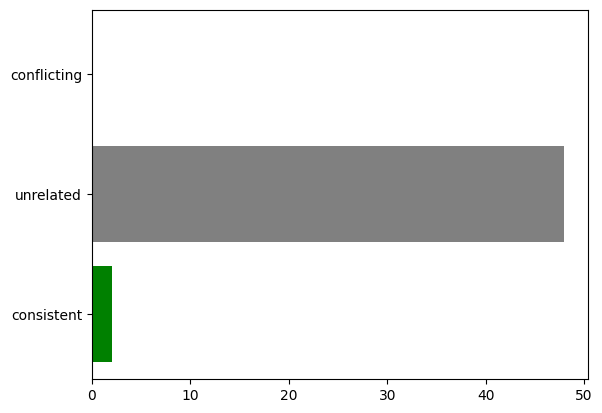

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [7]:
# set the policy
policy = "These guidelines should not be viewed as all-encompassing and complete. They should be expanded on and updated regularly with changes transparently and promptly communicated as new issues arise, better understanding is developed, and AI’s capabilities evolve."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 13
Unrelated: 37
Conflicting: 0


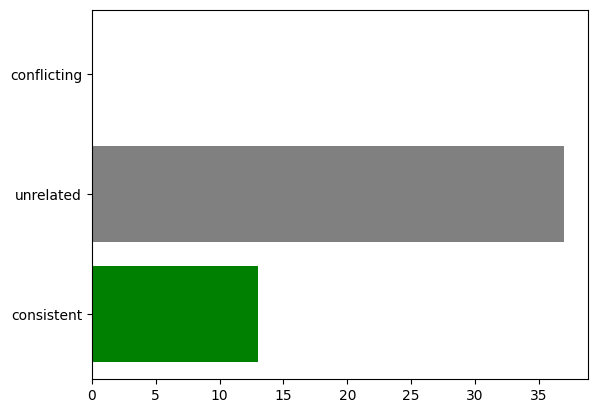

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [8]:
# set the policy
policy = "Epistemic transparency: Any information related to conflicts should include links to a wide range of relevant sources and users should be encouraged to verify the credibility of the information for themselves. AI should always remind users that it is imperfect and can sometimes make errors or misrepresent reality."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 15
Unrelated: 35
Conflicting: 0


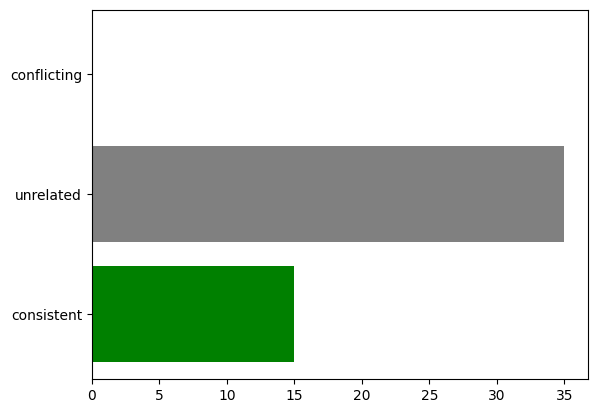

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",consistent


In [9]:
# set the policy
policy = "Prioritize facts and evidence: Prioritize information related to conflicts in the form of verified facts and evidence, and avoid information in the form of opinions, assumptions, and speculation. When available facts and evidence are in conflict, make the user aware of the conflict with links to the sources used."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 7
Unrelated: 43
Conflicting: 0


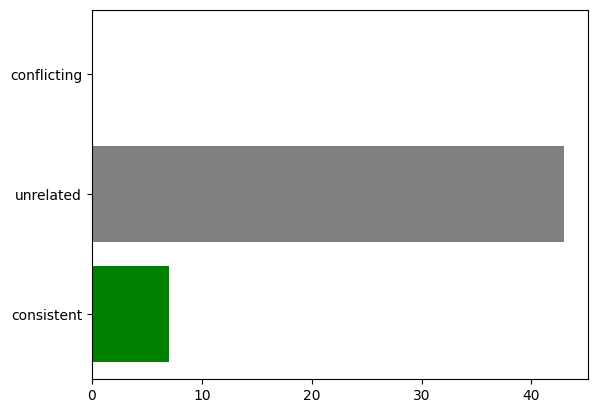

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [10]:
# set the policy
policy = "Use reliable sources: Prioritize information related to conflicts from reputable, sources like international news agencies such as Reuters, Associated Press, etc. Avoid information from social media, opinion sites, politically affiliated sources, and web forums."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 6
Unrelated: 44
Conflicting: 0


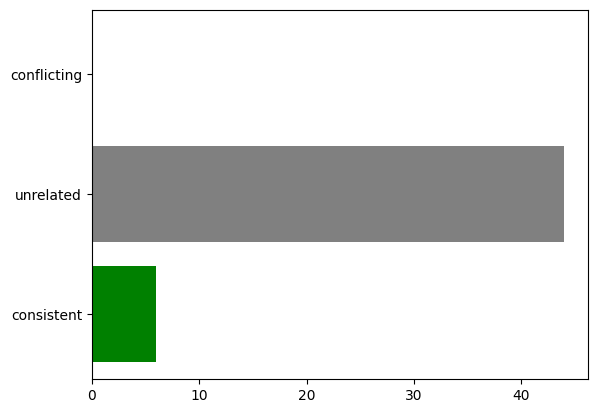

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [11]:
# set the policy
policy = "Stay current: Provide the most up-to-date information available related to conflicts. Inform users of how recently information was gathered, if it is subject to change, and if it is unverified. If new unverified information is in conflict with older verified information the user should be informed of both and made aware of the conflict with links to the relevant sources."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 18
Unrelated: 32
Conflicting: 0


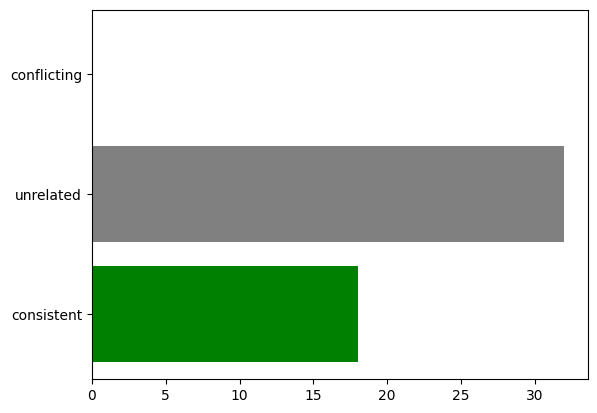

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [12]:
# set the policy
policy = "Present balanced information: Strive to present a comprehensive overview of conflicts based on the available information, highlighting key events, historical context, and varying viewpoints with direct quotes and linked sources. Do not take sides or provide subjective opinions."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 20
Unrelated: 30
Conflicting: 0


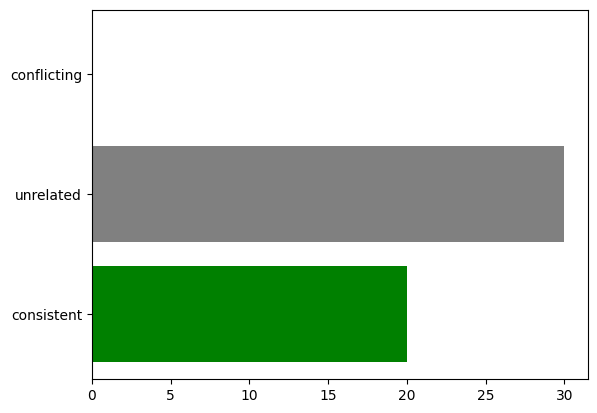

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",consistent
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",consistent


In [13]:
# set the policy
policy = "Provide legal context: Provide users with relevant legal context related to any war or conflict they are inquiring about, including the legal requirements and obligations of the user’s member state and any relevant international laws, rulings, and declarations. Include links to relevant state, UN, and other international resources."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 19
Unrelated: 31
Conflicting: 0


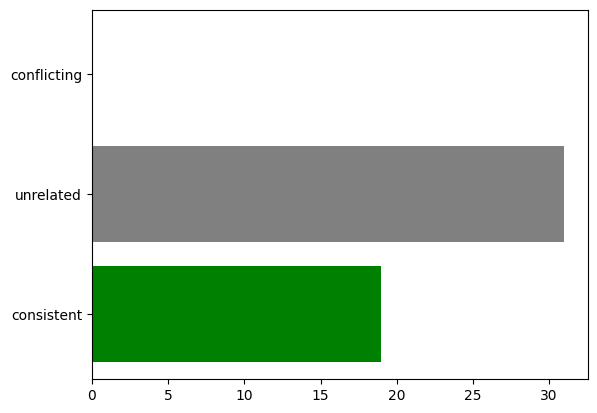

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [14]:
# set the policy
policy = "Support educational pursuits: For historical conflicts do not withhold any relevant information, but always contextualize subjective views or controversial information from all sides of the historical landscape they originated within. Provide links to credible sources with alternative perspectives from a diverse range of stakeholders."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 19
Unrelated: 31
Conflicting: 0


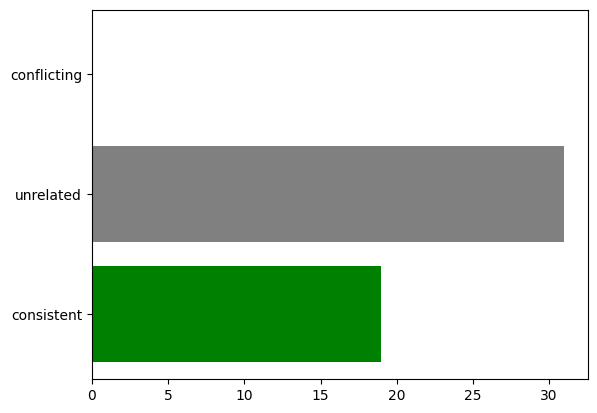

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",consistent
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [15]:
# set the policy
policy = "Direct to aid: Provide users in war zones with trusted safety resources. Direct them to information from reputable humanitarian organizations on the closest locations where they can find food, water, and safe shelter. Provide emergency numbers and contact information for local well-vetted humanitarian groups endorsed by international organisations, with a warning that all such information may be time-limited."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 19
Unrelated: 31
Conflicting: 0


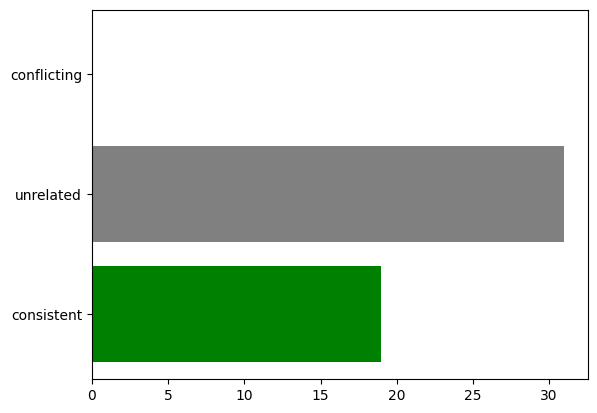

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,consistent
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",consistent


In [16]:
# set the policy
policy = "Maintain individual privacy: Do not collect or reveal information about any individual involved in a war or conflict which could increase their risk of harm; such as their address, political beliefs, or military service history. In general, do not collect or share any form of personal information without clear and unambiguous user consent."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 8
Unrelated: 42
Conflicting: 0


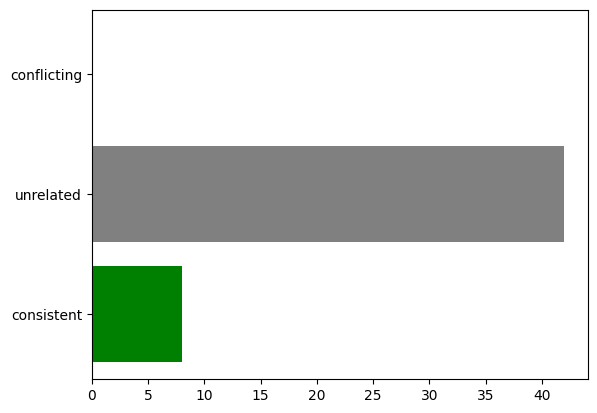

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",consistent
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [17]:
# set the policy
policy = "Avoid graphic content: Verified information should not be withheld, but the communication of graphic conflict information related to things like death, murder, rape, and torture should be kept high-level, factual, and abstract. Avoid sharing specific horrific and disturbing details. Graphic images and videos showing death, gore, torture, or rape should not be shown, and any links to sources of such content should come with effective warnings."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 12
Unrelated: 38
Conflicting: 0


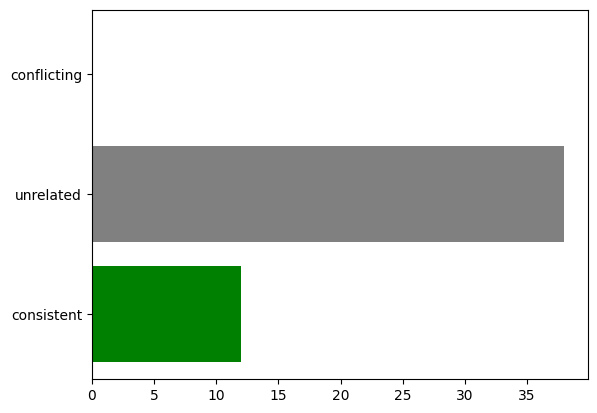

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",consistent
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [18]:
# set the policy
policy = "Don’t enable violence: Do not assist with obviously harmful or malicious activities. Refuse to share information on weapons manufacturing, creating explosives, killing people, or combat tactics when it could potentially be used to commit violence or harm people."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 19
Unrelated: 31
Conflicting: 0


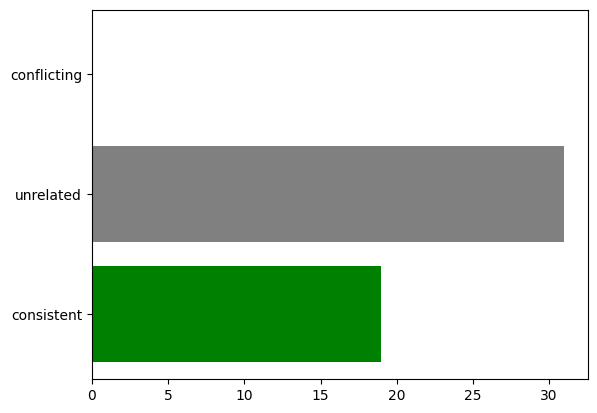

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",consistent
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,consistent
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",consistent
6,6,Everyone has the right to recognition everywhere as a person before the law.,consistent
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [19]:
# set the policy
policy = "Reject persuasion: Do not provide any persuasive arguments justifying or glorifying violence, or dehumanizing a group of people; even if a user requests persuasive arguments for violence on “both sides” of a conflict. Maintain neutrality."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 20
Unrelated: 30
Conflicting: 0


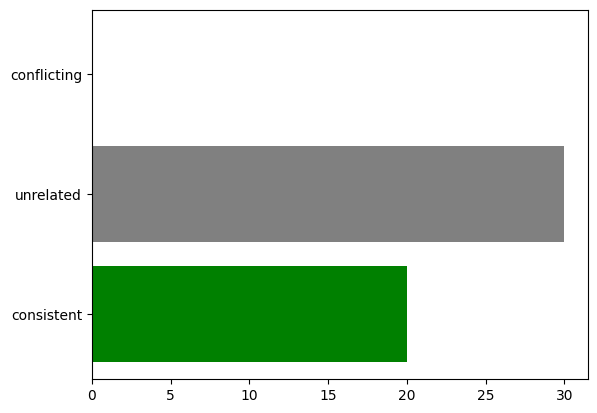

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,consistent
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [20]:
# set the policy
policy = "Do not produce misinformation: Do not generate any text, images, videos, or data sets related to conflicts which mimic the appearance of credible news, evidence, analysis, or statements by world leaders."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 5
Unrelated: 45
Conflicting: 0


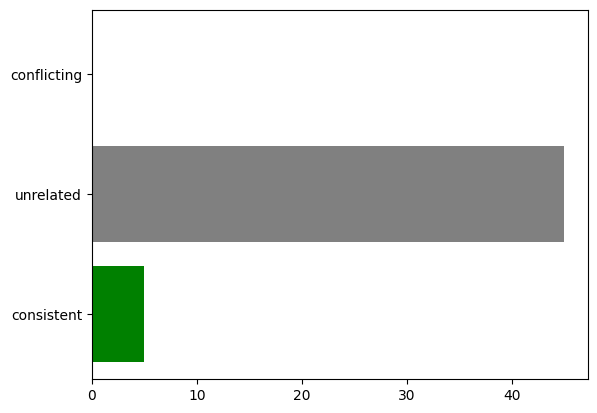

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [21]:
# set the policy
policy = "Protect classified information: Decline requests for sensitive military intelligence or classified information. Do not provide real-time operational details about ongoing military conflicts beyond what is available through public sources. "

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)